Tensor("dense_32/Sigmoid:0", shape=(?, 784), dtype=float32)


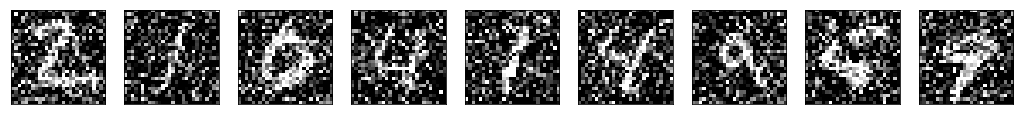

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2874 - val_loss: 0.2565
Epoch 2/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2485 - val_loss: 0.2412
Epoch 3/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.2327 - val_loss: 0.2235
Epoch 4/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2138 - val_loss: 0.2043
Epoch 5/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2009 - val_loss: 0.1948
Epoch 6/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.1891 - val_loss: 0.1814
Epoch 7/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.1808 - val_loss: 0.1788
Epoch 8/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.1745 - val_loss: 0.1729
Epoch 9/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1692 - val_loss: 0.1

60000/60000 [==============================] - 2s 36us/step - loss: 0.1187 - val_loss: 0.1213
Epoch 78/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1185 - val_loss: 0.1207
Epoch 79/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1183 - val_loss: 0.1218
Epoch 80/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1182 - val_loss: 0.1198
Epoch 81/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1180 - val_loss: 0.1220
Epoch 82/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1178 - val_loss: 0.1206
Epoch 83/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1177 - val_loss: 0.1194
Epoch 84/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1175 - val_loss: 0.1193
Epoch 85/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1175 - val_loss: 0.1208
Epoch 86/100
60000/60000 [========================

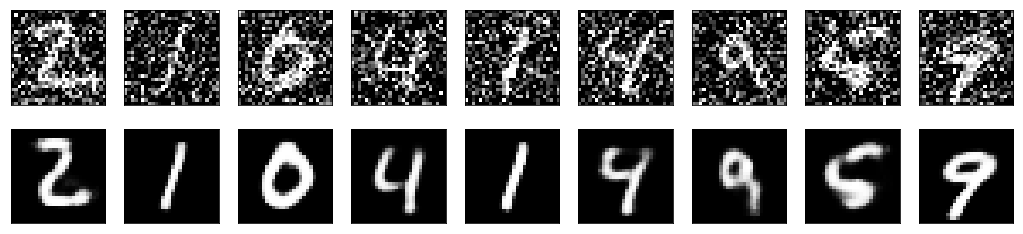

In [5]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras import backend as K
from keras.datasets import mnist
import numpy as np



# this is the size of our encoded representations
encoding_dim = 32
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input


# 784-> 32 Dense Net
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
# 32->784 Dense Net
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
# this model maps an input to its reconstruction
# input_img->encoded->decoded 과정을 하나로 묶겠다
# 말그대로 전체 과정임
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# input_img 를 넣으면 encoded 과정 까지만 하겠음.
encoder = Model(input_img, encoded)


# create a placeholder for an encoded (32-dimensional) input
# 파이썬 특징 , [encoding_dim][알맞은 사이즈] 로 구성된 데이터를 받는 구조.
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
# autoencoder 과정을 지나면 데이터는 784->32->784 가 된다
# layer[-1]  마지막 하나를 가지고 오는 거이므로 결국 decoder 된 값을 가지게 된다.
decoder_layer1 = autoencoder.layers[-1]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-4]
print(decoded)
# create the decoder model
#encoded_input을 넣어서 decoder_layer를 가져온다.
decoder = Model(encoded_input,
                decoder_layer1(decoder_layer2(decoder_layer3(encoded_input))))

#우리는 autoencoder 과정을 통해서 입력과 출력이 같은지 비교
# test 값이 따로 필요가 없음. x값이 입력이자 결과임
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 784,))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 784,))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



#x_train을 가지고 압축 하고 복구 할꺼임, 그렇기 때문에 y = x_train
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])


# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib (don't ask)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
